In [1]:
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.4 MB/s 
     |████████████████████████████████| 4.0 MB 8.9 MB/s 
     |████████████████████████████████| 1.2 MB 51.6 MB/s 
     |████████████████████████████████| 77 kB 8.8 MB/s 
     |████████████████████████████████| 6.6 MB 72.6 MB/s 
     |████████████████████████████████| 596 kB 78.5 MB/s 
     |████████████████████████████████| 880 kB 55.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=c407ec0cd0a2d1ff6f2c094bc809b7da5b7fc4e070d8b8eeb0e3c8a695a7fa92
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=b93314db8d73489915d270d3de84168e0f99a5de3cbbe0f68fe23467dca6e505
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sentence-transformers sac

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, IterableDataset
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [4]:
# os.chdir('..')
os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [5]:
from fashion_recommendations.metrics.average_precision import mapk

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
class RecommendationDatasetMultiLabel(IterableDataset):

    def __init__(self, dataset_filepath, article_emb_bag, total_articles):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.article_emb_bag = article_emb_bag
        
        self.total_articles = total_articles
    
    def process_label(self, label_str: str):
        
        labels = torch.tensor([int(v) for v in label_str.split(',')])
        
        target = torch.zeros(self.total_articles).scatter_(0, labels, 1.)

        target = target / target.sum()  # Normalise

        return target
    
    def mean_historical_purchases_embedding(self, input_str: str):
        
        indices = torch.tensor([int(v) for v in input_str.split(',')])

        mean_emb = self.article_emb_bag(indices.unsqueeze(0)).flatten()
            
        return mean_emb
    
    def process_numeric_features(self, fn: str, active: str, age: str):
        numeric_features_tensor = torch.tensor([
            float(fn),
            float(active),
            float(age)
        ])

        return numeric_features_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')
            
            customer_id_idx, article_id_idx_last10, article_id_idx_label, fn, active, age = line_items
            
            customer_id_idx = int(customer_id_idx)
            
            numeric_features_tensor = self.process_numeric_features(fn, active, age)
            
            mean_emb = self.mean_historical_purchases_embedding(article_id_idx_last10)

            label = self.process_label(article_id_idx_label)    
            
            inputs = torch.concat((mean_emb, numeric_features_tensor))

            yield customer_id_idx, inputs, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

In [11]:
articles_df = pd.read_csv('data/articles_df_filt.csv', dtype={'article_id': str})
print(articles_df.shape)
articles_df.head()

(40538, 3)


,article_id,detail_desc,article_id_idx
0,0108775015,Jersey top with narrow shoulder straps.,0
1,0108775044,Jersey top with narrow shoulder straps.,1
2,0110065001,"Microfibre T-shirt bra with underwired, moulde...",2
3,0110065002,"Microfibre T-shirt bra with underwired, moulde...",3
4,0110065011,"Microfibre T-shirt bra with underwired, moulde...",4


In [12]:
customers = pd.read_csv('data/customers_filt.csv')
print(customers.shape)
customers.head()

(43108, 5)


,customer_id,FN,Active,age,customer_id_idx
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0.0,0.0,0.45,0
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,1.0,1.0,0.44,1
2,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0.0,0.0,0.21,2
3,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,0.33,3
4,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0.0,0.0,0.21,4


### Create article EmbeddingBag

In [13]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [14]:
article_descriptions = articles_df['detail_desc'].to_list()
article_descriptions[:5]

['Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.']

In [15]:
embeddings = model.encode(article_descriptions)

In [16]:
embeddings = torch.tensor(embeddings)

In [17]:
embeddings.shape

torch.Size([40538, 384])

In [18]:
ARTICLE_EMBEDDING_BAG = nn.EmbeddingBag.from_pretrained(embeddings=embeddings, freeze=True)

### Model

In [19]:
class FashionRecV3(nn.Module):

    def __init__(self, user_embedding_dim):
        super(FashionRecV3, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customers), embedding_dim=user_embedding_dim)        
        
        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        
        # FC layers
        self.fc_1 = nn.Linear(in_features=user_embedding_dim+384+3, out_features=2048)            
        self.fc_2 = nn.Linear(in_features=2048, out_features=1024)
        # self.fc_3 = nn.Linear(in_features=1024, out_features=512)
        self.fc_3 = nn.Linear(in_features=1024, out_features=len(articles_df))
        
        # Activation functions
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(0.01)
        
    def forward(
        self, 
        customer_id_idx, 
        inputs
    ):

        user_emb = self.user_embeddings(customer_id_idx)
              
        concatenated_features = torch.concat(
            [
                user_emb, 
                inputs
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_features)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc_3(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        
        # x = self.fc_4(x)

        return x

In [20]:
fashion_rec_v3 = FashionRecV3(user_embedding_dim=384)

In [21]:
fashion_rec_v3.to(device)

FashionRecV3(
  (user_embeddings): Embedding(43108, 384)
  (fc_1): Linear(in_features=771, out_features=2048, bias=True)
  (fc_2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_3): Linear(in_features=1024, out_features=40538, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.01, inplace=False)
)

In [22]:
BATCH_SIZE = 1024

In [23]:
total_training_examples = pd.read_csv('data/final_train_set.tsv', sep='\t').shape[0]
total_batches = np.ceil(total_training_examples/BATCH_SIZE)
total_batches

43.0

In [24]:
total_dev_examples = pd.read_csv('data/final_dev_set.tsv', sep='\t').shape[0]
total_dev_batches = np.ceil(total_dev_examples/BATCH_SIZE)
total_dev_batches

9.0

In [25]:
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=fashion_rec_v3.parameters(), lr=0.001)  # 0.0001
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [26]:
MAX_EPOCHS = 75

training_losses = []
dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    # Since we use an IterableDataset we need to reinstaniate the dataset since file end will have been reached:
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    for data in tqdm(train_loader, total=total_batches):
        
        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        loss = criterion(y_pred, label)

        loss.backward()    
        
        optimizer.step()
        
    # scheduler.step()
    
    # Compute train loss:
    
    total_train_loss = 0

    fashion_rec_v3.eval()
    
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(train_loader, total=total_batches):

            customer_id_idx, inputs, label = data
            customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            y_pred = fashion_rec_v3(customer_id_idx, inputs)

            # loss = nn.BCEWithLogitsLoss(reduction='sum')(y_pred, label)
            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / total_training_examples
        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)
        
    # Compute dev loss:
    
    total_dev_loss = 0
    
    dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(dev_loader, total=total_dev_batches):

            customer_id_idx, inputs, label = data
            customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

            # optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            y_pred = fashion_rec_v3(customer_id_idx, inputs)

            # loss = nn.BCEWithLogitsLoss(reduction='sum')(y_pred, label)
            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

            total_dev_loss += loss.item()

        mean_dev_loss = total_train_loss / total_dev_examples
        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)
        
    fashion_rec_v3.train()

100%|██████████| 43/43.0 [00:11<00:00,  3.87it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.52it/s]


Training loss: 8.640836293947125


100%|██████████| 9/9.0 [00:02<00:00,  3.48it/s]


Dev loss: 40.84311085081937


100%|██████████| 43/43.0 [00:11<00:00,  3.88it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.52it/s]


Training loss: 8.419285522472265


100%|██████████| 9/9.0 [00:02<00:00,  3.47it/s]


Dev loss: 39.79589477003666


100%|██████████| 43/43.0 [00:11<00:00,  3.86it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.51it/s]


Training loss: 8.32822910297157


100%|██████████| 9/9.0 [00:02<00:00,  3.44it/s]


Dev loss: 39.36549343979149


100%|██████████| 43/43.0 [00:10<00:00,  3.94it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.42it/s]


Training loss: 8.270274630678689


100%|██████████| 9/9.0 [00:02<00:00,  3.38it/s]


Dev loss: 39.091556883694835


100%|██████████| 43/43.0 [00:11<00:00,  3.90it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.49it/s]


Training loss: 8.07691831536535


100%|██████████| 9/9.0 [00:02<00:00,  3.40it/s]


Dev loss: 38.1776090722335


100%|██████████| 43/43.0 [00:11<00:00,  3.82it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.44it/s]


Training loss: 7.99226261594471


100%|██████████| 9/9.0 [00:02<00:00,  3.32it/s]


Dev loss: 37.77746237370006


100%|██████████| 43/43.0 [00:11<00:00,  3.78it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.46it/s]


Training loss: 7.868837230378316


100%|██████████| 9/9.0 [00:02<00:00,  3.39it/s]


Dev loss: 37.1940608911347


100%|██████████| 43/43.0 [00:11<00:00,  3.75it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.43it/s]


Training loss: 7.736108577969323


100%|██████████| 9/9.0 [00:02<00:00,  3.36it/s]


Dev loss: 36.56668515121728


100%|██████████| 43/43.0 [00:11<00:00,  3.79it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.52it/s]


Training loss: 7.28946613794224


100%|██████████| 9/9.0 [00:02<00:00,  3.40it/s]


Dev loss: 34.45551603886119


100%|██████████| 43/43.0 [00:11<00:00,  3.84it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.46it/s]


Training loss: 6.978737822532034


100%|██████████| 9/9.0 [00:02<00:00,  3.24it/s]


Dev loss: 32.986779611152514


100%|██████████| 43/43.0 [00:11<00:00,  3.91it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.43it/s]


Training loss: 6.9131240271300785


100%|██████████| 9/9.0 [00:02<00:00,  3.37it/s]


Dev loss: 32.676639315956514


100%|██████████| 43/43.0 [00:10<00:00,  3.92it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.44it/s]


Training loss: 6.539949058723149


100%|██████████| 9/9.0 [00:02<00:00,  3.42it/s]


Dev loss: 30.912732897306743


100%|██████████| 43/43.0 [00:11<00:00,  3.91it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.39it/s]


Training loss: 6.20682541492466


100%|██████████| 9/9.0 [00:02<00:00,  3.34it/s]


Dev loss: 29.338139252913624


100%|██████████| 43/43.0 [00:11<00:00,  3.79it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.46it/s]


Training loss: 6.060706356034779


100%|██████████| 9/9.0 [00:02<00:00,  3.35it/s]


Dev loss: 28.647470350432815


100%|██████████| 43/43.0 [00:11<00:00,  3.78it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.52it/s]


Training loss: 5.861289027273251


100%|██████████| 9/9.0 [00:02<00:00,  3.42it/s]


Dev loss: 27.704873617071854


100%|██████████| 43/43.0 [00:11<00:00,  3.87it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.49it/s]


Training loss: 5.387542751510831


100%|██████████| 9/9.0 [00:02<00:00,  3.41it/s]


Dev loss: 25.46559133027729


100%|██████████| 43/43.0 [00:11<00:00,  3.78it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.42it/s]


Training loss: 5.326948035810856


100%|██████████| 9/9.0 [00:02<00:00,  3.42it/s]


Dev loss: 25.17917499207614


100%|██████████| 43/43.0 [00:11<00:00,  3.84it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.36it/s]


Training loss: 4.8333242893705695


100%|██████████| 9/9.0 [00:02<00:00,  3.42it/s]


Dev loss: 22.845936783573084


100%|██████████| 43/43.0 [00:11<00:00,  3.89it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.39it/s]


Training loss: 5.3465070934212475


100%|██████████| 9/9.0 [00:02<00:00,  3.49it/s]


Dev loss: 25.271625853421394


100%|██████████| 43/43.0 [00:11<00:00,  3.87it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.42it/s]


Training loss: 5.572809059190498


100%|██████████| 9/9.0 [00:02<00:00,  3.30it/s]


Dev loss: 26.341299662673684


100%|██████████| 43/43.0 [00:11<00:00,  3.79it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.45it/s]


Training loss: 5.211020308699249


100%|██████████| 9/9.0 [00:02<00:00,  3.39it/s]


Dev loss: 24.631213099496406


100%|██████████| 43/43.0 [00:11<00:00,  3.79it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.47it/s]


Training loss: 4.735350336359949


100%|██████████| 9/9.0 [00:02<00:00,  3.36it/s]


Dev loss: 22.38283797146981


100%|██████████| 43/43.0 [00:11<00:00,  3.79it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.51it/s]


Training loss: 4.017966980238157


100%|██████████| 9/9.0 [00:02<00:00,  3.28it/s]


Dev loss: 18.9919430465029


100%|██████████| 43/43.0 [00:11<00:00,  3.87it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.47it/s]


Training loss: 3.860411986710024


100%|██████████| 9/9.0 [00:02<00:00,  3.44it/s]


Dev loss: 18.247219289813124


100%|██████████| 43/43.0 [00:11<00:00,  3.89it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.40it/s]


Training loss: 3.645927546008173


100%|██████████| 9/9.0 [00:02<00:00,  3.45it/s]


Dev loss: 17.23340401900442


100%|██████████| 43/43.0 [00:11<00:00,  3.90it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.41it/s]


Training loss: 3.370869354335831


100%|██████████| 9/9.0 [00:02<00:00,  3.36it/s]


Dev loss: 15.9332715051216


100%|██████████| 43/43.0 [00:11<00:00,  3.86it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.47it/s]


Training loss: 3.1888056196949197


100%|██████████| 9/9.0 [00:02<00:00,  3.34it/s]


Dev loss: 15.072700948882522


100%|██████████| 43/43.0 [00:11<00:00,  3.87it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.48it/s]


Training loss: 3.2033192327605047


100%|██████████| 9/9.0 [00:02<00:00,  3.45it/s]


Dev loss: 15.141303233096474


100%|██████████| 43/43.0 [00:11<00:00,  3.77it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.48it/s]


Training loss: 2.830355031598507


100%|██████████| 9/9.0 [00:02<00:00,  3.44it/s]


Dev loss: 13.3783930594461


100%|██████████| 43/43.0 [00:11<00:00,  3.87it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.54it/s]


Training loss: 2.7903081662603775


100%|██████████| 9/9.0 [00:02<00:00,  3.24it/s]


Dev loss: 13.18910136306495


100%|██████████| 43/43.0 [00:11<00:00,  3.89it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.40it/s]


Training loss: 2.633454080613345


100%|██████████| 9/9.0 [00:02<00:00,  3.34it/s]


Dev loss: 12.447690625776325


100%|██████████| 43/43.0 [00:11<00:00,  3.80it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.45it/s]


Training loss: 2.383637279529258


100%|██████████| 9/9.0 [00:02<00:00,  3.35it/s]


Dev loss: 11.266867965564392


100%|██████████| 43/43.0 [00:10<00:00,  3.91it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.47it/s]


Training loss: 2.3753779233359245


100%|██████████| 9/9.0 [00:02<00:00,  3.47it/s]


Dev loss: 11.227828017452307


100%|██████████| 43/43.0 [00:11<00:00,  3.90it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.50it/s]


Training loss: 2.2369960492181793


100%|██████████| 9/9.0 [00:02<00:00,  3.41it/s]


Dev loss: 10.573730887028209


100%|██████████| 43/43.0 [00:11<00:00,  3.87it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.48it/s]


Training loss: 2.2218738459275342


100%|██████████| 9/9.0 [00:02<00:00,  3.41it/s]


Dev loss: 10.5022519462987


100%|██████████| 43/43.0 [00:11<00:00,  3.81it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.51it/s]


Training loss: 2.1228096317667524


100%|██████████| 9/9.0 [00:02<00:00,  3.36it/s]


Dev loss: 10.033999737522059


100%|██████████| 43/43.0 [00:11<00:00,  3.82it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.48it/s]


Training loss: 1.9496451701128583


100%|██████████| 9/9.0 [00:02<00:00,  3.25it/s]


Dev loss: 9.21549385890626


100%|██████████| 43/43.0 [00:11<00:00,  3.86it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.46it/s]


Training loss: 1.8854778068919809


100%|██████████| 9/9.0 [00:02<00:00,  3.37it/s]


Dev loss: 8.912190493366175


100%|██████████| 43/43.0 [00:11<00:00,  3.90it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.46it/s]


Training loss: 1.830698139494731


100%|██████████| 9/9.0 [00:02<00:00,  3.34it/s]


Dev loss: 8.653260460234526


100%|██████████| 43/43.0 [00:11<00:00,  3.83it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.39it/s]


Training loss: 1.7139335466667884


100%|██████████| 9/9.0 [00:02<00:00,  3.40it/s]


Dev loss: 8.101342908959639


100%|██████████| 43/43.0 [00:11<00:00,  3.87it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.44it/s]


Training loss: 1.6898832364527892


100%|██████████| 9/9.0 [00:02<00:00,  3.40it/s]


Dev loss: 7.9876629996718025


100%|██████████| 43/43.0 [00:11<00:00,  3.80it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.45it/s]


Training loss: 1.6921064625138573


100%|██████████| 9/9.0 [00:02<00:00,  3.40it/s]


Dev loss: 7.998171643206947


100%|██████████| 43/43.0 [00:11<00:00,  3.85it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.46it/s]


Training loss: 1.5684242807802269


100%|██████████| 9/9.0 [00:02<00:00,  3.42it/s]


Dev loss: 7.4135563482318005


100%|██████████| 43/43.0 [00:11<00:00,  3.78it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.44it/s]


Training loss: 1.5012957796024415


100%|██████████| 9/9.0 [00:02<00:00,  3.41it/s]


Dev loss: 7.096256410866453


100%|██████████| 43/43.0 [00:10<00:00,  3.94it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.43it/s]


Training loss: 1.5023782954340335


100%|██████████| 9/9.0 [00:02<00:00,  3.36it/s]


Dev loss: 7.101373197321307


100%|██████████| 43/43.0 [00:11<00:00,  3.89it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.46it/s]


Training loss: 1.4969038758459743


100%|██████████| 9/9.0 [00:02<00:00,  3.46it/s]


Dev loss: 7.075496960522836


100%|██████████| 43/43.0 [00:10<00:00,  3.93it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.50it/s]


Training loss: 1.4334728383969273


100%|██████████| 9/9.0 [00:02<00:00,  3.44it/s]


Dev loss: 6.775674026054248


100%|██████████| 43/43.0 [00:11<00:00,  3.86it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.52it/s]


Training loss: 1.3749859131941096


100%|██████████| 9/9.0 [00:02<00:00,  3.28it/s]


Dev loss: 6.499220695830228


100%|██████████| 43/43.0 [00:11<00:00,  3.80it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.54it/s]


Training loss: 1.344419100802916


100%|██████████| 9/9.0 [00:02<00:00,  3.51it/s]


Dev loss: 6.354738881295187


100%|██████████| 43/43.0 [00:11<00:00,  3.84it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.55it/s]


Training loss: 1.3359474558395326


100%|██████████| 9/9.0 [00:02<00:00,  3.25it/s]


Dev loss: 6.314695496308176


100%|██████████| 43/43.0 [00:11<00:00,  3.90it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.49it/s]


Training loss: 1.3029440431788646


100%|██████████| 9/9.0 [00:02<00:00,  3.42it/s]


Dev loss: 6.158696470762554


100%|██████████| 43/43.0 [00:11<00:00,  3.88it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.47it/s]


Training loss: 1.2674840035305357


100%|██████████| 9/9.0 [00:02<00:00,  3.50it/s]


Dev loss: 5.991085572828326


100%|██████████| 43/43.0 [00:10<00:00,  3.96it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.48it/s]


Training loss: 1.254118759645163


100%|██████████| 9/9.0 [00:02<00:00,  3.42it/s]


Dev loss: 5.927911347673651


100%|██████████| 43/43.0 [00:10<00:00,  3.95it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.50it/s]


Training loss: 1.246725636709043


100%|██████████| 9/9.0 [00:02<00:00,  3.34it/s]


Dev loss: 5.892965871409366


100%|██████████| 43/43.0 [00:11<00:00,  3.83it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.52it/s]


Training loss: 1.2228862514320635


100%|██████████| 9/9.0 [00:02<00:00,  3.36it/s]


Dev loss: 5.780282952492697


100%|██████████| 43/43.0 [00:11<00:00,  3.86it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.56it/s]


Training loss: 1.195412579434053


100%|██████████| 9/9.0 [00:02<00:00,  3.47it/s]


Dev loss: 5.65042165287754


100%|██████████| 43/43.0 [00:11<00:00,  3.88it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.55it/s]


Training loss: 1.1890955563322494


100%|██████████| 9/9.0 [00:02<00:00,  3.29it/s]


Dev loss: 5.6205626362248475


100%|██████████| 43/43.0 [00:10<00:00,  3.94it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.47it/s]


Training loss: 1.1967615065796318


100%|██████████| 9/9.0 [00:02<00:00,  3.44it/s]


Dev loss: 5.656797700179251


100%|██████████| 43/43.0 [00:10<00:00,  3.95it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.50it/s]


Training loss: 1.1788973628208104


100%|██████████| 9/9.0 [00:02<00:00,  3.51it/s]


Dev loss: 5.572358280315734


100%|██████████| 43/43.0 [00:10<00:00,  3.99it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.53it/s]


Training loss: 1.1626297525188372


100%|██████████| 9/9.0 [00:02<00:00,  3.35it/s]


Dev loss: 5.495465281971714


100%|██████████| 43/43.0 [00:11<00:00,  3.88it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.56it/s]


Training loss: 1.1558420264987497


100%|██████████| 9/9.0 [00:02<00:00,  3.43it/s]


Dev loss: 5.463381368235538


100%|██████████| 43/43.0 [00:11<00:00,  3.90it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.55it/s]


Training loss: 1.137379021461857


100%|██████████| 9/9.0 [00:02<00:00,  3.50it/s]


Dev loss: 5.376111278199313


100%|██████████| 43/43.0 [00:11<00:00,  3.87it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.53it/s]


Training loss: 1.147591926353124


100%|██████████| 9/9.0 [00:02<00:00,  3.38it/s]


Dev loss: 5.424385171187551


100%|██████████| 43/43.0 [00:11<00:00,  3.86it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.51it/s]


Training loss: 1.1426117854469215


100%|██████████| 9/9.0 [00:02<00:00,  3.21it/s]


Dev loss: 5.400845268316436


100%|██████████| 43/43.0 [00:10<00:00,  3.94it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.49it/s]


Training loss: 1.1390012458092629


100%|██████████| 9/9.0 [00:02<00:00,  3.43it/s]


Dev loss: 5.3837791342484325


100%|██████████| 43/43.0 [00:10<00:00,  3.94it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.46it/s]


Training loss: 1.127023847866138


100%|██████████| 9/9.0 [00:02<00:00,  3.42it/s]


Dev loss: 5.32716491598832


100%|██████████| 43/43.0 [00:10<00:00,  3.95it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.48it/s]


Training loss: 1.1100752385303971


100%|██████████| 9/9.0 [00:02<00:00,  3.46it/s]


Dev loss: 5.247053002474601


100%|██████████| 43/43.0 [00:11<00:00,  3.85it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.54it/s]


Training loss: 1.1039923568531613


100%|██████████| 9/9.0 [00:02<00:00,  3.45it/s]


Dev loss: 5.2183007148274205


100%|██████████| 43/43.0 [00:11<00:00,  3.84it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.52it/s]


Training loss: 1.1038209667915513


100%|██████████| 9/9.0 [00:02<00:00,  3.44it/s]


Dev loss: 5.217490596101995


100%|██████████| 43/43.0 [00:11<00:00,  3.87it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.51it/s]


Training loss: 1.0974915553922389


100%|██████████| 9/9.0 [00:02<00:00,  3.28it/s]


Dev loss: 5.187573023009718


100%|██████████| 43/43.0 [00:11<00:00,  3.80it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.48it/s]


Training loss: 1.1007124506233685


100%|██████████| 9/9.0 [00:02<00:00,  3.51it/s]


Dev loss: 5.202797403670194


100%|██████████| 43/43.0 [00:10<00:00,  3.93it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.47it/s]


Training loss: 1.0880076973051334


100%|██████████| 9/9.0 [00:02<00:00,  3.46it/s]


Dev loss: 5.142745155200624


100%|██████████| 43/43.0 [00:10<00:00,  3.94it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.48it/s]


Training loss: 1.0850080100926107


100%|██████████| 9/9.0 [00:02<00:00,  3.42it/s]


Dev loss: 5.12856637051231


100%|██████████| 43/43.0 [00:10<00:00,  3.96it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.51it/s]


Training loss: 1.0823269699194376


100%|██████████| 9/9.0 [00:02<00:00,  3.49it/s]


Dev loss: 5.115893752114815


100%|██████████| 43/43.0 [00:10<00:00,  3.91it/s]
100%|██████████| 43/43.0 [00:12<00:00,  3.57it/s]


Training loss: 1.0888516837661006


100%|██████████| 9/9.0 [00:02<00:00,  3.49it/s]

Dev loss: 5.146734471906695


In [27]:
training_losses[-1], dev_losses[-1]

(1.0888516837661006, 5.146734471906695)

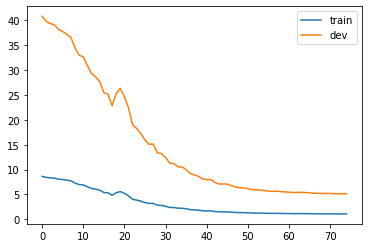

In [28]:
plt.plot(training_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()
plt.show()

### MAP@12

#### Train

In [29]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 43/43.0 [00:10<00:00,  3.94it/s]


In [30]:
predictions = torch.concat(predictions)

In [31]:
predictions.shape

torch.Size([43108, 12])

In [32]:
actuals = pd.read_csv('data/final_train_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

43108

In [33]:
mapk(actuals, predictions.tolist(), 12)

0.9840845808203853

🤯

#### Dev

In [34]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_dev_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 9/9.0 [00:02<00:00,  3.97it/s]


In [35]:
predictions = torch.concat(predictions)

In [36]:
predictions.shape

torch.Size([9120, 12])

In [37]:
actuals = pd.read_csv('data/final_dev_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

9120

In [38]:
mapk(actuals, predictions.tolist(), 12)

0.05123407822512681

#### Test

In [39]:
total_test_batches = np.ceil(pd.read_csv('data/final_test_set.tsv', sep='\t').shape[0]/BATCH_SIZE)

In [40]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_test_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_test_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 9/9.0 [00:02<00:00,  4.08it/s]


In [41]:
predictions = torch.concat(predictions)

In [42]:
predictions.shape

torch.Size([8733, 12])

In [43]:
actuals = pd.read_csv('data/final_test_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

8733

In [44]:
mapk(actuals, predictions.tolist(), 12)

0.01689692373029523

In [45]:
# Number of unique items in predictions
len(predictions.unique())

9899

In [46]:
# Number of unique items in actuals
len(set([item for sublist in actuals for item in sublist]))

8318

### Submission

In [ ]:
total_sub_batches = np.ceil(pd.read_csv('data/final_submission_inputs.tsv', sep='\t').shape[0]/BATCH_SIZE)
total_sub_batches

43.0

In [ ]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_submission_inputs.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_sub_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 43/43.0 [00:09<00:00,  4.56it/s]


In [ ]:
predictions = torch.concat(predictions)

In [ ]:
predictions.shape

torch.Size([43108, 12])

In [ ]:
sample_submission = pd.read_csv('data/sample_submission.csv')
print(sample_submission.shape)
sample_submission.head()

(1371980, 2)


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


In [ ]:
article_idx_to_id = dict(zip(articles_df['article_id_idx'], articles_df['article_id']))

In [ ]:
predictions_article_id = [[article_idx_to_id[i] for i in l] for l in predictions.tolist()]
predictions_article_id[0]

['0685814001',
 '0685814005',
 '0685814003',
 '0685814033',
 '0685814065',
 '0685814022',
 '0794575017',
 '0685814063',
 '0919499007',
 '0794575001',
 '0456163083',
 '0850917001']

In [ ]:
predictions_strings = [' '.join(l) for l in predictions_article_id]
predictions_strings[0]

'0685814001 0685814005 0685814003 0685814033 0685814065 0685814022 0794575017 0685814063 0919499007 0794575001 0456163083 0850917001'

In [ ]:
submission_set_filt = pd.read_csv('data/final_submission_inputs.tsv', sep='\t')
print(submission_set_filt.shape)
submission_set_filt.head()

(43108, 6)


,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age
0,0,"15861,7705,7705,7705",0,0.0,0.0,0.45
1,1,"17255,26222,39644,31316,3160,38515,39642,40340...",0,1.0,1.0,0.44
2,2,"21627,21175,23351,23816",0,0.0,0.0,0.21
3,3,"36213,38872,37897,38110,5642,4783,34346,34346,...",0,1.0,1.0,0.33
4,4,"21522,31083,23930,15224,21141,37733,10396,3782...",0,0.0,0.0,0.21


In [ ]:
len(predictions_strings)

43108

In [ ]:
customer_idx_to_id = dict(zip(customers['customer_id_idx'], customers['customer_id']))

In [ ]:
submission_set_filt['customer_id'] = submission_set_filt['customer_id_idx'].map(customer_idx_to_id)

In [ ]:
submission_set_filt['prediction_model'] = predictions_strings

In [ ]:
submission_set_filt.isnull().sum()

customer_id_idx          0
article_id_idx_last10    0
article_id_idx_label     0
FN                       0
Active                   0
age                      0
customer_id              0
prediction_model         0
dtype: int64

In [ ]:
submission_set_filt.head()

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,customer_id,prediction_model
0,0,"15861,7705,7705,7705",0,0.0,0.0,0.45,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0685814001 0685814005 0685814003 0685814033 06...
1,1,"17255,26222,39644,31316,3160,38515,39642,40340...",0,1.0,1.0,0.44,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0935858001 0909869004 0888024005 0923134003 05...
2,2,"21627,21175,23351,23816",0,0.0,0.0,0.21,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0820671001 0910933001 0399223001 0760084015 07...
3,3,"36213,38872,37897,38110,5642,4783,34346,34346,...",0,1.0,1.0,0.33,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0904026001 0905914002 0913367001 0574109039 07...
4,4,"21522,31083,23930,15224,21141,37733,10396,3782...",0,0.0,0.0,0.21,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0759814022 0937066001 0806388019 0759814036 08...


In [ ]:
sample_submission = sample_submission.merge(submission_set_filt[['customer_id', 'prediction_model']], on='customer_id', how='left')
sample_submission.head()

,customer_id,prediction,prediction_model
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...,NaN
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...,NaN
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...,NaN
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...,NaN
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...,NaN


In [ ]:
sample_submission.isnull().sum()

customer_id               0
prediction                0
prediction_model    1328872
dtype: int64

In [ ]:
sample_submission['prediction_model'].fillna(
    '0751471001 0706016001 0372860002 0610776002 0448509014 0730683050 0918292001 0760084003 0866731001 0372860001 0827968001 0706016003',
    inplace=True
)

In [ ]:
sample_submission.drop(columns=['prediction'], inplace=True)
sample_submission.rename(columns={'prediction_model': 'prediction'}, inplace=True)

In [ ]:
sample_submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0751471001 0706016001 0372860002 0610776002 04...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0751471001 0706016001 0372860002 0610776002 04...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0751471001 0706016001 0372860002 0610776002 04...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0751471001 0706016001 0372860002 0610776002 04...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0751471001 0706016001 0372860002 0610776002 04...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0809961007 0720125039 0791587015 0896559001 08...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0751471001 0706016001 0372860002 0610776002 04...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0751471001 0706016001 0372860002 0610776002 04...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0751471001 0706016001 0372860002 0610776002 04...


In [ ]:
sample_submission.to_csv('data/20220503-fashionrecv3_2.csv', index=False)

In [ ]:
# Top-12 baseline
# sample_submission['prediction'] = '0751471001 0706016001 0372860002 0610776002 0448509014 0730683050 0918292001 0760084003 0866731001 0372860001 0827968001 0706016003'

In [ ]:
# sample_submission.to_csv('submissions/20220502-top12-recent-period.csv', index=False)

- Switching for `BCELoss` to `CrossEntropyLoss` made a HUGE difference
- For the first time we are able to overfit the training set achieving 99% MAP@12!
- Despite this, MAP@12 for the following week (dev set) is 0.05
- MAP@12 is 0.017 for the test set, suggesting that the further ahead we use the model the more performance degrades
- This is potentially why leaderboard performance (week after test) is lower still: 0.0055 (beating top-12 baseline of 0.0046)
- Since the model seems to learn in a stable manner as a next step we will train using the full training set (using last week as labels) to then make predictions for the submission. Hopefully performance on the submission set will then be close to observed dev performance in the model here